# Use small set of data

For experimenting in local computer with limited resource

In [1]:
import math
import pandas as pd
import cv2
import numpy as np
from concurrent.futures import ProcessPoolExecutor
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.applications import ResNet50, InceptionResNetV2
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.callbacks import Callback, LearningRateScheduler
from keras.optimizers import SGD
from matplotlib import pyplot as plt
from IPython.display import clear_output
from sklearn.linear_model import LogisticRegression

Using TensorFlow backend.


## Get top labels
get labels with more data in it.

In [2]:
num_classes = 10
df = pd.read_csv('data2/labels.csv')

# get top 10 breed
breed = df.groupby(['breed'])['breed'].count().nlargest(num_classes)
breed = [i for i in breed.index]  # get index name only

# labels in breed
labels = df[df['breed'].isin(breed)]

## Preparing data and labels

In [3]:
ROWS = 250
COLS = 250
CHANNELS = 3
CORE = 4


def resize_img(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR)
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    with ProcessPoolExecutor(max_workers=CORE) as executor:
        data[:] = list(executor.map(resize_img, images))
    
    return data


lb = LabelBinarizer()

files = ['data2/train/%s.jpg' % i['id'] for _, i in labels.iterrows()]
text_labels = [i['breed'] for _, i in labels.iterrows()]

x = prep_data(files)
y = lb.fit_transform(text_labels)

## Split dataset for train and test

In [4]:
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.20, random_state=42)

## Feature extraction

In [5]:
inc = ResNet50(include_top=False, weights='imagenet')

features_train = inc.predict(x_train, verbose=1)
features_valid = inc.predict(x_valid, verbose=1)

229/229 [==============================] - 124s 541ms/step


## Model

In [39]:
model = Sequential()
model.add(Flatten(input_shape=features_train.shape[1:]))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(num_classes, activation='softmax'))

lr = 0.001
sgd = SGD(lr=lr, momentum=0.9, decay=1e-6, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['categorical_accuracy'])

## Train network

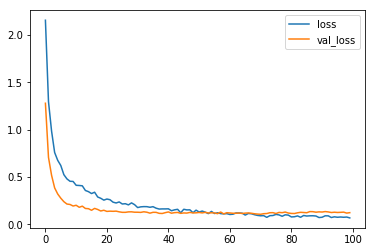

912/912 [==============================] - 0s 286us/step - loss: 0.0682 - categorical_accuracy: 0.9846 - val_loss: 0.1236 - val_categorical_accuracy: 0.9651


In [40]:
class PlotLosses(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show()
        
        
def lr_schedule(epoch):
    return lr * math.pow(0.5, math.floor((1 + epoch)/50.0))

        
plot_losses = PlotLosses()
model.fit(
    features_train, y_train,
    batch_size=32,
    epochs=100,
    validation_data=(features_valid, y_valid),
    verbose=1,
    callbacks=[plot_losses]
)

In [41]:
model.evaluate(features_valid, y_valid)

229/229 [==============================] - 0s 83us/step


[0.12364604062396692, 0.96506550218340614]